# 第三课：图神经网络

图神经网络（Graph Neural Network, GNN）是深度神经网络（Deep Neural Network, DNN）在图数据上的泛化，它是非常强力的图特征提取工具。在本次实践课中，我们将讲解常见的图神经网络比如GCN和GAT，以及如何利用图神经网络来完成节点分类和图分类问题。

## 1. GCN

### 1.1 用矩阵形式实现GCN

首先我们来回顾一下GCN每一层的操作。给定图的邻接矩阵$A$和节点特征矩阵$X$，如果我们用$W$表示GCN层中的参数、$H$表示隐藏层的特征，那么一层GCN中的操作可以表达为$H=\text{ReLU}(AXW)$。其中:

* $A \in R^{N \times N}$
* $X \in R^{N \times d_{in}}$
* $W \in R^{d_{in} \times d_{out}}$

In [1]:
# set up session:
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
import torch.optim as optim
from torch.nn.parameter import Parameter
from sklearn.metrics import f1_score
import scipy.sparse as sp
import numpy as np

In [2]:
class GraphConvolution(nn.Module):
    """ GCN layer, reference -- https://github.com/tkipf/pygcn
    """
    def __init__(self, in_features, out_features, with_bias=True):
        super(GraphConvolution, self).__init__()
        # set dimensions of layer params, W:
        self.in_features = in_features
        self.out_features = out_features
        
        # define layer params, weight and bias:
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if with_bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        
        # init params:
        self.reset_parameters()

    def reset_parameters(self): 
        """ init layer params
        """
        stdv = 1. / math.sqrt(self.weight.size(1))
        
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x, adj):
        """ forward propagation
        """
        # do X × W:
        if x.data.is_sparse:
            support = torch.spmm(x, self.weight) 
        else:
            support = torch.mm(x, self.weight)
        # do A × (X × W):
        output = torch.spmm(adj, support)
        
         # do A × X × W + b:
        if self.bias is not None:
            return output + self.bias
        else:
            return output

In [3]:
class GCN(nn.Module):
    """ demo GCN
    """
    def __init__(self, nfeat, nhid, nclass, dropout=0.5, with_bias=True):
        super(GCN, self).__init__()

        self.nfeat = nfeat
        self.hidden_sizes = [nhid]
        self.nclass = nclass
        self.gc1 = GraphConvolution(nfeat, nhid, with_bias=with_bias)
        self.gc2 = GraphConvolution(nhid, nclass, with_bias=with_bias)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

    def initialize(self):
        self.gc1.reset_parameters()
        self.gc2.reset_parameters()

定义好GCN模型后，我们来简单看看怎么使用这个模型。我们继续以Cora数据集为例。

In [4]:
from dgl.data import CoraGraphDataset

# get graph dataset:
graph_dataset = CoraGraphDataset('./data')[0]

A = graph_dataset.adj(scipy_fmt='coo')
X = graph_dataset.ndata['feat']
Y = graph_dataset.ndata['label']

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [5]:
# adjacency matrix A overview:
A

<2708x2708 sparse matrix of type '<class 'numpy.int64'>'
	with 10556 stored elements in COOrdinate format>

In [6]:
# raw node features X overview
X.shape

torch.Size([2708, 1433])

接下来我们对邻接矩阵adj进行标准化（normalize）： 

$A \leftarrow A + I$

$\hat{A}= D^{-1/2}{A}D^{-1/2}$ 

In [7]:
def normalize_adj(A):
    """ Normalize A' = (D + I)^-1/2 * ( A + I ) * (D + I)^-1/2
    """
    (N, _) = A.shape
    A = A + sp.eye(N)
    
    D = np.array(A.sum(axis=0))
    D_root_inv = np.power(D, -1/2).flatten()
    D_root_inv[np.isinf(D_root_inv)] = 0.
    D_root_inv = sp.diags(D_root_inv)
    
    A_normalized = D_root_inv.dot(A)
    A_normalized = A_normalized.dot(D_root_inv)
    
    return A_normalized

In [8]:
A_normalized = normalize_adj(A)
A_normalized

<2708x2708 sparse matrix of type '<class 'numpy.float64'>'
	with 13264 stored elements in Compressed Sparse Row format>

In [9]:
def scipy_sparse_matrix_to_torch_sparse_tensor(sparse_matrix):
    """ Format scipy.sparse matrix as torch.sparse tensor
    """
    # format as i-j-v:
    sparse_matrix = sparse_matrix.tocoo().astype(np.float32)
    
    # as N by 1:
    indices_row = torch.LongTensor(sparse_matrix.row).unsqueeze(1)
    # as N by 1:
    indices_col = torch.LongTensor(sparse_matrix.col).unsqueeze(1)
    # as N by 2:
    indices=torch.cat(
        tensors=(indices_row, indices_col),
        dim=1
    ).t()
    
    data=torch.FloatTensor(sparse_matrix.data)
    
    return torch.sparse.FloatTensor(
        indices,
        data,
        torch.Size(sparse_matrix.shape)
    )

In [10]:
A_normalized = scipy_sparse_matrix_to_torch_sparse_tensor(A_normalized)
A_normalized

tensor(indices=tensor([[   0,    1,    2,  ..., 2707, 2706, 2707],
                       [   0,    0,    0,  ..., 2706, 2707, 2707]]),
       values=tensor([0.1667, 0.1826, 0.1826,  ..., 0.5000, 0.5000, 0.5000]),
       size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)

In [11]:
num_classes = len(Y.unique())

model = GCN(
    nfeat=X.shape[1], 
    nhid=16, 
    nclass=num_classes
)

output = model(X, A_normalized)

print(output.shape)
print(output)

torch.Size([2708, 7])
tensor([[-1.7952, -2.1526, -2.0200,  ..., -1.7102, -1.8746, -2.1321],
        [-1.8164, -2.1321, -2.0546,  ..., -1.7008, -1.8613, -2.1072],
        [-1.8326, -2.1486, -2.0127,  ..., -1.7016, -1.8640, -2.1313],
        ...,
        [-1.8614, -2.1255, -2.0373,  ..., -1.7949, -1.8291, -2.0835],
        [-1.6645, -2.3507, -1.8296,  ..., -1.6876, -2.0921, -2.2105],
        [-1.6645, -2.3507, -1.8296,  ..., -1.6876, -2.0921, -2.2105]],
       grad_fn=<LogSoftmaxBackward0>)


### 1.2 DGL实现GCN

在这个小节，我们通过DGL来实现GCN。DGL中GCN的实现与上面用矩阵乘法的实现的核心不同是：

*DGL中，`graph`是核心数据结构，GNN的操作是对`graph`进行，而不是`torch.SparseTensor`。*


In [12]:
graph_dataset

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'__orig__': Scheme(shape=(), dtype=torch.int64)})

#### 1.2.1 直接调用DGL提供的接口

In [13]:
from dgl.nn import GraphConv

class GCN(torch.nn.Module):
    """ 2层GCN
    
    参数说明
    ----------
    nfeat : 输入特征的维度
    nhid : 隐藏神经元的数量
    nclass : 输出神经元的数量，也即类别的数量
    dropout : dropout中的概率
    with_bias: 是否带有偏置项
    """

    def __init__(self, nfeat, nhid, nclass, dropout=0.5, with_bias=True):
        super(GCN, self).__init__()
        
        #
        # Generalized GCN in DGL: https://docs.dgl.ai/en/0.6.x/api/python/nn.pytorch.html#graphconv
        #
        self.conv1 = GraphConv(nfeat, nhid, bias=with_bias, activation=F.relu)
        self.conv2 = GraphConv(nhid, nclass, bias=with_bias)
        self.dropout = dropout
        
    def reset_parameters(self):
        """初始化模型参数"""
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, g, features):
        """ forward propagation
        """
        h = self.conv1(g, features)
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.conv2(g, h)
        
        return F.log_softmax(h, dim=1)

In [14]:
num_classes = len(Y.unique())

model = GCN(nfeat=X.shape[1], nhid=16, nclass=num_classes)
output = model(graph_dataset, X)

print(output)
print(output.shape)

tensor([[-1.9542, -1.9485, -1.9450,  ..., -1.9430, -1.9461, -1.9406],
        [-1.9524, -1.9434, -1.9450,  ..., -1.9439, -1.9489, -1.9434],
        [-1.9524, -1.9434, -1.9450,  ..., -1.9439, -1.9489, -1.9434],
        ...,
        [-1.9475, -1.9464, -1.9475,  ..., -1.9445, -1.9481, -1.9446],
        [-1.9471, -1.9456, -1.9454,  ..., -1.9443, -1.9469, -1.9457],
        [-1.9471, -1.9472, -1.9463,  ..., -1.9433, -1.9462, -1.9455]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([2708, 7])


#### 1.2.2 详细讲解`GraphConv`内部结构

下面这部分代码来自DGL中的[graphconv.py](https://github.com/dmlc/dgl/blob/master/python/dgl/nn/pytorch/conv/graphconv.py#L141)，这里做了一些修改（删除了一些不重要的变量和更高级选项逻辑的代码）来让它更简洁易懂。

In [15]:
import torch as th
from torch import nn
from torch.nn import init
from dgl import function as fn
from dgl.utils import expand_as_pair


class GraphConv(nn.Module):
    """ reference https://docs.dgl.ai/en/0.6.x/api/python/nn.pytorch.html#graphconv
    """
    
    def __init__(
        self,
        in_feats,           # 输入的维度
        out_feats,          # 输出的维度
        bias=True,          # 是否使用bias
        activation=None     # 使用哪种激活函数
    ):   
        super(GraphConv, self).__init__()
        
        self._in_feats = in_feats
        self._out_feats = out_feats
        
        # init weight:
        self.weight = nn.Parameter(th.Tensor(in_feats, out_feats))
        # init bias:
        if bias:
            self.bias = nn.Parameter(th.Tensor(out_feats))
        else:
            self.register_parameter('bias', None)
            
        # init params:
        self.reset_parameters()
        
        # set activation function
        self._activation = activation

    def reset_parameters(self):
        if self.weight is not None:
            init.xavier_uniform_(self.weight)
        if self.bias is not None:
            init.zeros_(self.bias)

    def forward(self, graph, feat):
        with graph.local_scope():
            # GCN的消息传递函数就是复制邻居的特征
            msg_fn = fn.copy_src('h', 'm')
            
            # 对节点的特征按出度进行标准化
            feat_src, feat_dst = expand_as_pair(feat, graph)
            degs = graph.out_degrees().float().clamp(min=1)
            norm = th.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feat_src.dim() - 1)
            norm = th.reshape(norm, shp)
            feat_src = feat_src * norm
            # 先进行维度变换，并送进图里的节点
            feat_src = th.matmul(feat_src, self.weight)
            graph.srcdata['h'] = feat_src
            # DGL最核心的消息传递+聚合更新的函数
            graph.update_all(msg_fn, fn.sum(msg='m', out='h'))
            # 从图里把计算后的特征取出
            rst = graph.dstdata['h']
            
            # 再对节点的特征按入度进行标准化
            degs = graph.in_degrees().float().clamp(min=1)
            norm = th.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feat_dst.dim() - 1)
            norm = th.reshape(norm, shp)
            rst = rst * norm

            if self.bias is not None:
                rst = rst + self.bias

            if self._activation is not None:
                rst = self._activation(rst)

            return rst

这里有几个需要注意的地方：

1. `foward()`函数中需要使用`fn.copy_src()`在节点之间进行信息的传递。`fn.copy_src()`是DGL内置的多种消息函数之一。它的输入是源节点数据(一个字典)里以`h`为键的值, 输出是`m`，这是一个在边上数据(一个字典)的字典，字典的键为`m`。
1. `fn.sum()`函数是DGL内置的聚合函数之一，它把来自边上数据`m`在目标节点上加和，成为目标节点数据(一个字典)，字典的键为`h`。
1. 如果同学们需要设计自己的GNN模型的话，通常是改变`消息`和`聚合`函数。更多关于DGL内置的消息函数和聚合函数可以在[DGL built-in functions](https://docs.dgl.ai/api/python/dgl.function.html#dgl-built-in-function)里看到。
1. 对于DGL的GraphConv的细节，可以在[dgl.nn.graphconv](https://docs.dgl.ai/api/python/nn.pytorch.html#graphconv)找到。


## 2. GAT

In [16]:
from dgl.nn import GATConv

class GAT(nn.Module):
    """ 2层GAT.
    
    参数说明
    ----------
    nfeat : 输入特征的维度
    nhid : 隐藏神经元的数量
    nclass : 输出神经元的数量，也即类别的数量
    heads: 注意力机制中的head数量
    output_heads: 输出曾的head数量
    dropout : dropout中的概率
    acitvation: 使用哪种激活函数
    with_bias: 是否带有偏置项
    """

    def __init__(self, nfeat, nhid, nclass, heads=8, output_heads=1, dropout=0.5, activation=F.elu, with_bias=True):

        super(GAT, self).__init__()
        
        #
        # reference https://docs.dgl.ai/en/0.6.x/api/python/nn.pytorch.html#gatconv
        #
        self.conv1 = GATConv(
            nfeat,
            nhid,
            num_heads=heads,
            feat_drop=dropout,
            attn_drop=dropout,
            activation=activation,
            bias=with_bias
        )

        self.conv2 = GATConv(
            nhid * heads,
            nclass,
            num_heads=output_heads,
            activation=activation,
            bias=with_bias
        )

    def forward(self, g, features):
        h = self.conv1(g, features).flatten(1)
        h = self.conv2(g, h).flatten(1)
        return F.log_softmax(h, dim=1)

    def initialize(self):
        """Initialize parameters of GAT.
        """
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

In [17]:
gat = GAT(
    nfeat=X.shape[1],
    nhid=8, 
    nclass=num_classes, 
    heads=8
)

output = gat(graph_dataset, X)
print(output)
print(output.shape)

tensor([[-1.9381, -1.9438, -1.9646,  ..., -1.9175, -1.9640, -1.9509],
        [-1.9356, -1.9519, -1.9620,  ..., -1.9252, -1.9593, -1.9513],
        [-1.9356, -1.9519, -1.9620,  ..., -1.9252, -1.9593, -1.9513],
        ...,
        [-1.9218, -1.9005, -1.9794,  ..., -1.8987, -1.9729, -1.9996],
        [-1.9296, -1.9372, -1.9413,  ..., -1.9243, -1.9554, -1.9900],
        [-2.0035, -1.9270, -1.9451,  ..., -1.9323, -1.9587, -1.9117]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([2708, 7])


关于`GATConv`的具体实现，参见[gatconv.py](https://github.com/dmlc/dgl/blob/master/python/dgl/nn/pytorch/conv/gatconv.py#L13)。学有余力的同学可以尝试理解下其中`消息`和`聚合`函数的实现。

简单来讲，
1. `GATConv`里的`edge_softmax()`函数实现了注意力分数（attention score），这个分数就是`alpha`，它是每个相连接的节点对的拼接后的特征通过一个线性层得到的。`alpha`的值会作为边的数据(一个字典)，字典的键值为`a`。
2. 在得到`alpha`值后，在进行消息传递时，会使用DGL的内置消息函数`fn.u_mul_e()`把源节点的特征乘上`alpha`之后，在作为消息传送到边上的数据(一个字典)，字典的键是`ft`。然后再使用聚合函数`fn.sum()`完成对边上数据的加和。

## 3. 利用GCN完成节点分类任务

关于节点分类任务，其实我们在上一次课（图嵌入）的时候已经有了初步的接触：我们用DeepWalk对Cora数据集上的节点进行了分类。在这里，我们同样以Cora数据集为例，来展示如何进行节点分类。

In [18]:
def train(model, g, lr=0.01, weight_decay=5e-4, epochs=200):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    mask = g.ndata['train_mask']
    X = g.ndata['feat']
    Y_truth = g.ndata['label']
    
    best_loss_val = 100

    for i in range(epochs):
        model.train()
        
        optimizer.zero_grad()
        Y_prob = model(g, X)

        loss = F.nll_loss(Y_prob[mask], Y_truth[mask])
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print('Epoch {}, training loss: {}'.format(i, loss.item()))

@torch.no_grad()
def test(model, g):
    """Evaluate GAT performance on test set.
    """
    model.eval()
    
    mask = g.ndata['test_mask']
    
    X = g.ndata['feat']
    Y_truth = g.ndata['label']
    
    # make predictions -- take the most likely one as final prediction:
    Y_prob = model(g, X)
    Y_pred = Y_prob.argmax(1)
    
    # test set loss:
    loss = F.nll_loss(Y_prob[mask], Y_truth[mask]).item()
    # test set accuracy:
    acc = Y_pred[mask].eq(Y_truth[mask]).cpu().numpy().mean().item()
    
    print(
        "Evaluation results:",
        "\tloss= {:.4f}".format(loss),
        "\taccuracy= {:.4f}".format(acc)
    )
    
    return Y_pred, Y_prob, acc

In [19]:
model = GCN(
    nfeat=X.shape[1], 
    nhid=16, 
    nclass=num_classes
)

device = 'cuda:0'
model = model.to(device)
graph_dataset = graph_dataset.to(device)

train(model, graph_dataset, epochs=100)

Epoch 0, training loss: 1.9461957216262817
Epoch 10, training loss: 1.8698285818099976
Epoch 20, training loss: 1.7328319549560547
Epoch 30, training loss: 1.552354097366333
Epoch 40, training loss: 1.3609699010849
Epoch 50, training loss: 1.1227672100067139
Epoch 60, training loss: 0.9950242042541504
Epoch 70, training loss: 0.8483349680900574
Epoch 80, training loss: 0.759131133556366
Epoch 90, training loss: 0.6394556760787964


In [20]:
pred, prob, acc = test(model, graph_dataset)

Test set results: 	loss= 1.0505 	accuracy= 0.8130


接下来我们使用tsne对得到的输出进行降维并可视化。

/opt/anaconda/envs/graph/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda/envs/graph/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


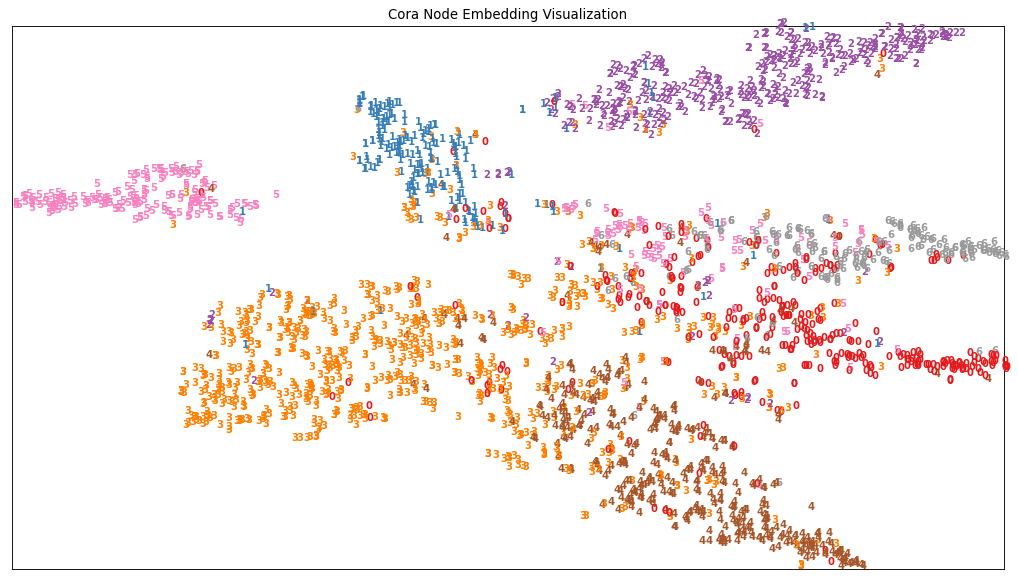

In [21]:
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

def plot_embedding(
    embeddings, labels, 
    title
):
    """plot node embedding with tSNE"""
    # fit tSNE:
    tsne = TSNE(n_components=2, init='pca', random_state=42)
    data = tsne.fit_transform(embeddings)
    
    # preprocess for visualization:
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
     
    # visualize:
    (V, _) = data.shape
    
    fig = plt.figure(figsize=(16, 9), dpi=80)
    ax = plt.subplot(111)
    for node_id in range(V):
        plt.text(
            data[node_id, 0], data[node_id, 1], str(labels[node_id]),
            color=plt.cm.Set1(labels[node_id] / 6),
            fontdict={'weight': 'bold', 'size': 9}
        )
        
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    
    return fig

plt.show(
    plot_embedding(
        prob.cpu().numpy(), Y.cpu().numpy(), 
        'Cora Node Embedding Visualization'
    )
)

不难看出，得到的节点嵌入的分离度非常高，大家可以将这幅图和第二次实践课上的deepwalk得到的图进行对比。

## 4. 利用GCN完成图分类任务

在这一节中，我们将使用GCN完成图分类任务。

### 4.1 图分类数据集介绍

图分类任务中，每张图都对应了一个标签，节点是不对应标签的。本小节我们以ENZYMES数据集为例来介绍图分类任务。

In [22]:
from dgl.data import TUDataset
dataset = TUDataset(name='ENZYMES', raw_dir='./data/ENZYMES')

In [23]:
print(dataset)
print(len(dataset))

Dataset("ENZYMES", num_graphs=600, save_path=./data/ENZYMES/ENZYMES)
600


我们可以看到ENZYMES数据集一共有600张图。下面让我们取出第一张图来看看：

In [24]:
g, label = dataset[0]
print(g)
print(label)

Graph(num_nodes=37, num_edges=168,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'node_labels': Scheme(shape=(1,), dtype=torch.int64), 'node_attr': Scheme(shape=(18,), dtype=torch.float64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
tensor([5])


这张图中共有168条边，37个节点，以及一个标签5。这个标签代表的是这个图的标签，因为该数据集属于图分类数据集。

### 4.2 图分类任务实践

In [25]:
from dgl.nn.pytorch.glob import AvgPooling 

class GCN(torch.nn.Module):
    """3层GCN+1层线性层"""

    def __init__(self, nfeat, nhid, nclass, dropout=0.2):
        super(GCN, self).__init__()
        
        self.gc1 = GraphConv(nfeat, nhid, activation=F.relu)
        self.gc2 = GraphConv(nhid, nhid, activation=F.relu)
        self.gc3 = GraphConv(nhid, nhid, activation=F.relu)
        self.lin = nn.Linear(nhid, nclass)
        self.avgpool = AvgPooling()
        self.dropout = dropout

    def forward(self, g, features):
        """模型前向传播"""
        h = self.gc1(g, features)
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.gc2(g, h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.gc3(g, h)
        h = self.avgpool(g, h)
        h = self.lin(h)
        return F.log_softmax(h, dim=1)

In [26]:
from dgl.dataloading import GraphDataLoader
from dgl.data import TUDataset
from torch.utils.data import random_split

dataset = TUDataset(name='ENZYMES', raw_dir='./data/ENZYMES')

# 获取train和test的样本数量
train_num = int(0.8 * len(dataset))
test_num = int(0.2 * len(dataset))

# 使用Pytorch的random_split获取train和test的Dataset类
train_dataset, test_dataset = random_split(dataset, [train_num, test_num])

# 使用DGL的GraphDataLoader构建迷你批次数据
train_loader = GraphDataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = GraphDataLoader(test_dataset, batch_size=64)

In [30]:
# 从一个样本图里获取特征维度
g0, lable0 = dataset[0]

nfeat = g0.ndata['node_attr'].shape[1]
nclass = len(lable0.unique())
nhid = 64
device = 'cuda:0'

model = GCN(nfeat, nhid, nclass).to(device)

In [31]:
def train(model, lr=0.001, epochs=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        loss_all = 0
        for batch_graphs, batch_labels in train_loader:
            # 每个批次里获取特征和处理标签
            batch_graphs = batch_graphs.to(device)
            features = batch_graphs.ndata['node_attr'].float()
            batch_labels = batch_labels.squeeze(dim=1).to(device)
            
            optimizer.zero_grad()
            # 前向传播
            preds = model(batch_graphs, features)
            # 计算损失
            loss = F.nll_loss(preds, batch_labels)
            loss.backward()
            loss_all += loss.item() * batch_labels.shape[0]
            # 反向传播
            optimizer.step()
            
        loss_train = loss_all / train_num 
        if epoch % 100 == 0:
            print('Epoch: {:03d}, Loss: {:.7f}'.format(epoch, loss_train))

def test(model, valid_loader):
    model.eval()
    correct = 0
    for batch_graphs, batch_labels in valid_loader:

        batch_graphs = batch_graphs.to(device)
        features = batch_graphs.ndata['node_attr'].float()
        batch_labels = batch_labels.squeeze(dim=1).to(device)

        pred = model(batch_graphs, features)
        correct += float(th.sum(th.argmax(pred,dim=1) == batch_labels).item())
    return correct / test_num

In [32]:
train(model, epochs=1000)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
test(model, test_loader)